In [2]:
# Thêm thư viện
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os

In [2]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('dataset/'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [3]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)

#### Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.


In [4]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
model = VGG16(weights='imagenet', include_top=False)

-	Lưu ý : Kích thước của ảnh cũng chính là kích thước của dữ liệu sau khi chuyển thành ma trận, ví dụ ảnh có kích thước là 28*28 thì khi chuyển thành ma trận sẽ là 28*28*3 nếu là ảnh màu và 28*28*1 nếu là ảnh xám . Nếu transfer learning model thì phải điều chỉnh lại kích thước sao cho phù hợp với đầu vào của model đó . 

Dòng code này lặp qua từng đường dẫn ảnh trong danh sách `image_path`, sau đó thực hiện các bước tiền xử lý ảnh như sau:

1. Sử dụng hàm `load_img` để tải ảnh và resize về kích thước (224, 224).
2. Sử dụng hàm `img_to_array` để chuyển ảnh thành một mảng numpy.
3. Mở rộng chiều của mảng numpy sử dụng `np.expand_dims` để tạo thành một batch có kích thước (1, 224, 224, 3).
4. Tiền xử lý ảnh sử dụng `imagenet_utils.preprocess_input` để chuẩn bị cho việc đưa vào mô hình VGG16.
5. Thêm ảnh đã tiền xử lý vào danh sách `list_image`.
6. Cuối cùng, chuyển danh sách các ảnh thành một mảng numpy một chiều bằng cách sử dụng `np.vstack`.

In [5]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)
    
    # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    image = imagenet_utils.preprocess_input(image)
    
    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)
    
# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)


In [6]:
# Dùng pre-trained model để lấy ra các feature của ảnh 
features = model.predict(list_image)

# Giống bước flatten trong CNN, chuyển từ tensor 3 chiều sau ConvNet sang vector 1 chiều
features = features.reshape((features.shape[0], 512*7*7))

    # features = model.predict(list_image) => cho ra vector đặc trưng chứ không phải là one-hot


NHẮT LẠI : C:\Users\ADMIN\Downloads\DeepLearning\Learning\Chapter4_CNN\Lab4_MNIST_Detail.ipynb
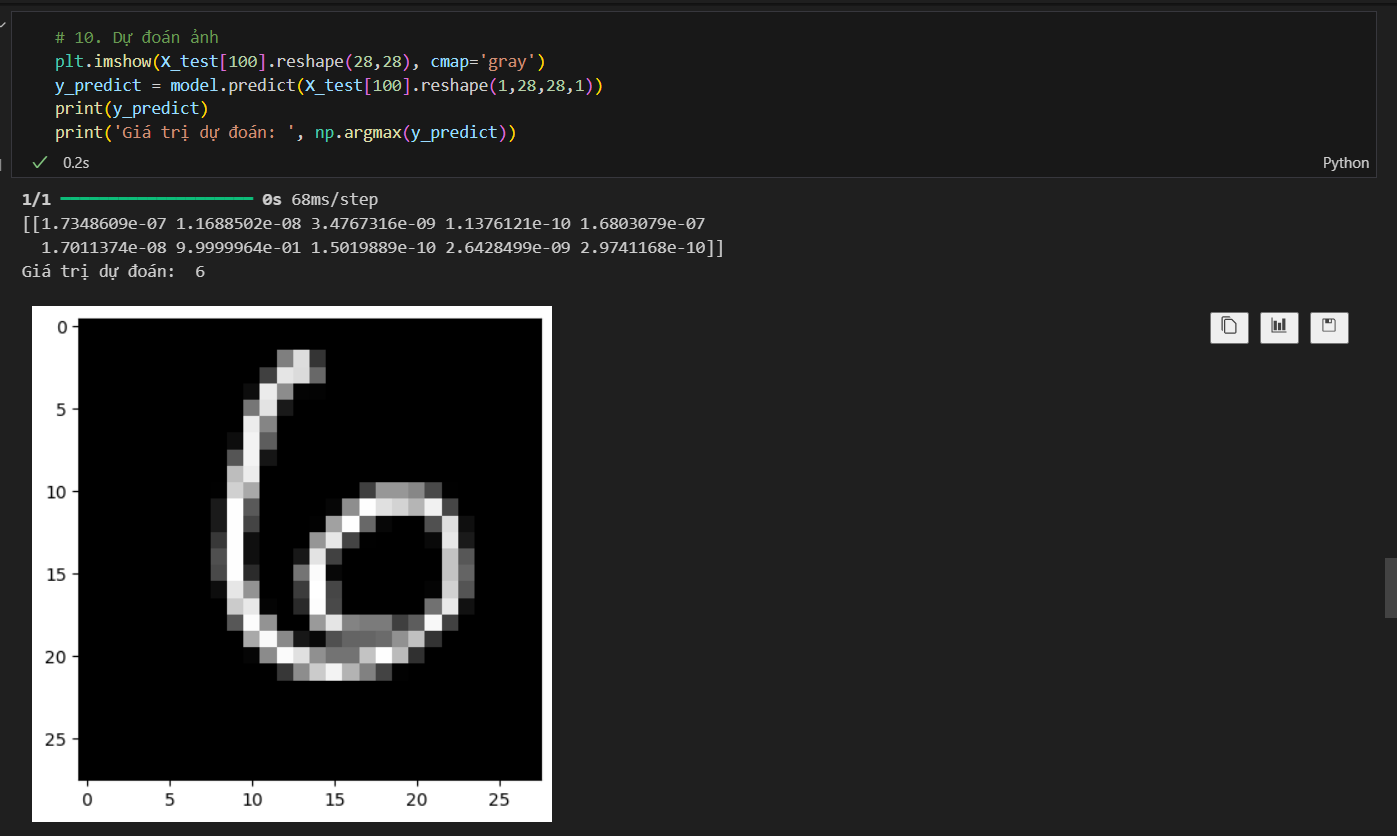
Trong ví dụ trên, bạn đã sử dụng mô hình để dự đoán một ảnh từ tập dữ liệu kiểm tra. Khi bạn gọi `model.predict(X_test[100].reshape(1,28,28,1))`, mô hình sẽ dự đoán lớp của ảnh được truyền vào. Kết quả trả về là một vector xác suất cho mỗi lớp có thể có. Trong trường hợp này, vector đó có 10 phần tử, mỗi phần tử thể hiện xác suất của mỗi lớp từ 0 đến 9.

Sau đó, bạn sử dụng `np.argmax(y_predict)` để tìm ra chỉ mục của phần tử có giá trị lớn nhất trong vector xác suất. Chỉ mục này tương ứng với lớp mà mô hình dự đoán cho ảnh đó. Trong trường hợp của bạn, chỉ mục đó là 6, nghĩa là mô hình dự đoán rằng ảnh đó chứa chữ số 6.

#### Ta có danh sách vector đặc trưng và label tương ứng của các vector đặc trưng , giờ chia nó ra thành dữ liệu để huấn luyện 

In [7]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Dòng code này thực hiện tìm kiếm lưới (grid search) để tìm ra các siêu tham số tốt nhất cho mô hình. Cụ thể:

- `params` là một từ điển chứa các giá trị của các siêu tham số cần tinh chỉnh. Trong trường hợp này, chúng ta tinh chỉnh siêu tham số `C`, là hệ số trong regularization.
- `GridSearchCV` là một công cụ từ thư viện scikit-learn giúp tìm ra các siêu tham số tối ưu bằng cách thử tất cả các tổ hợp có thể từ các giá trị đã chỉ định.
- `LogisticRegression()` tạo ra một mô hình hồi quy logistic mà chúng ta muốn tinh chỉnh.
- `model.fit(X_train, y_train)` thực hiện việc huấn luyện mô hình trên tập dữ liệu huấn luyện để tìm ra các giá trị siêu tham số tốt nhất.
- `model.best_params_` trả về các giá trị tối ưu nhất cho các siêu tham số được tìm thấy.

Kết quả là `model.best_params_` sẽ chứa các giá trị tối ưu nhất cho siêu tham số `C`.

In [11]:
# Grid search để tìm các parameter tốt nhất cho model. C = 1/lamda, hệ số trong regularisation. Solver là kiểu optimize
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = {'C' : [0.1, 1.0, 10.0, 100.0]}
#model = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='multinomial'), params)
model = GridSearchCV(LogisticRegression(), params) # KHỞI TẠO MODEL 
model.fit(X_train, y_train) # HUẤN LUYỆN MODEL 
print('Best parameter for the model {}'.format(model.best_params_)) 

Best parameter for the model {'C': 0.1}


In [12]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94        17
          1       0.91      0.77      0.83        13
          2       0.95      0.95      0.95        19
          3       0.62      0.91      0.74        11
          4       0.87      0.93      0.90        14
          5       0.86      0.86      0.86        14
          6       1.00      1.00      1.00        11
          7       0.92      0.85      0.88        13
          8       1.00      0.95      0.97        20
          9       1.00      0.94      0.97        18
         10       0.91      1.00      0.95        10
         11       1.00      0.94      0.97        16
         12       0.84      0.94      0.89        17
         13       1.00      1.00      1.00        19
         14       1.00      0.96      0.98        27
         15       0.75      0.69      0.72        13
         16       1.00      0.85      0.92        20

avg / total       0.93      0.92      0.92  